### Ce-bigFISH Image Analysis for single embryo for nd2 image files

#### Image info:

In [1]:
folder_name = '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_nd2_test-files' #your folder should contain 1 image

# User-defined channel names (set to None if the channel does not exist)
Cy5 = "set-3 mRNA"  # (Q670)
mCherry = "lin-41 mRNA"  # (Q610)
FITC = "LIN-41 GFP"  # (GFP)
DAPI = "DAPI"
brightfield = "brightfield"

In [2]:
#import packages:
import os
import matplotlib.pyplot as plt
import numpy as np

import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.multistack as multistack
import bigfish.detection as detection

import cellpose
from cellpose import models
# from cellpose import plot
import pandas as pd
import skimage
from skimage.measure import label, regionprops
from skimage.morphology import square, dilation,erosion
from skimage import measure, morphology

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from PIL import Image

# pip install nd2
import nd2


In [3]:
# Reading the microscopy data
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, folder_name)

if os.path.exists(folder_path):
    # List the files in the folder
    list_filenames = os.listdir(folder_path)
    list_filenames = sorted(list_filenames)
    path_files = [os.path.join(folder_path, filename) for filename in list_filenames if not filename.startswith('.ipynb_checkpoints')]

    # Read DV files and store image stacks in list_images
    list_images = []
    for image in path_files:
#         image_stack = stack.read_dv(image)
        image_stack = nd2.imread(image)
        list_images.append(image_stack)

# Converting the image to a specific shape
image_colors = list_images[0] # Reference [Y,X]
bf = image_colors[:, 4, :, :]
#Check dimensions of your data and establish order for future manipulations

image_name = list_filenames[0]
print(f'Image ID: {image_name}', '\n')

# print(f'Image files: {list_filenames}', '\n')
print(f'Image colors \n{list_filenames[0]}: {image_colors.shape} \n')



Image ID: 1085_crop.nd2 

Image colors 
1085_crop.nd2: (72, 5, 900, 1300) 



In [4]:
print(image_stack.dtype)

uint16


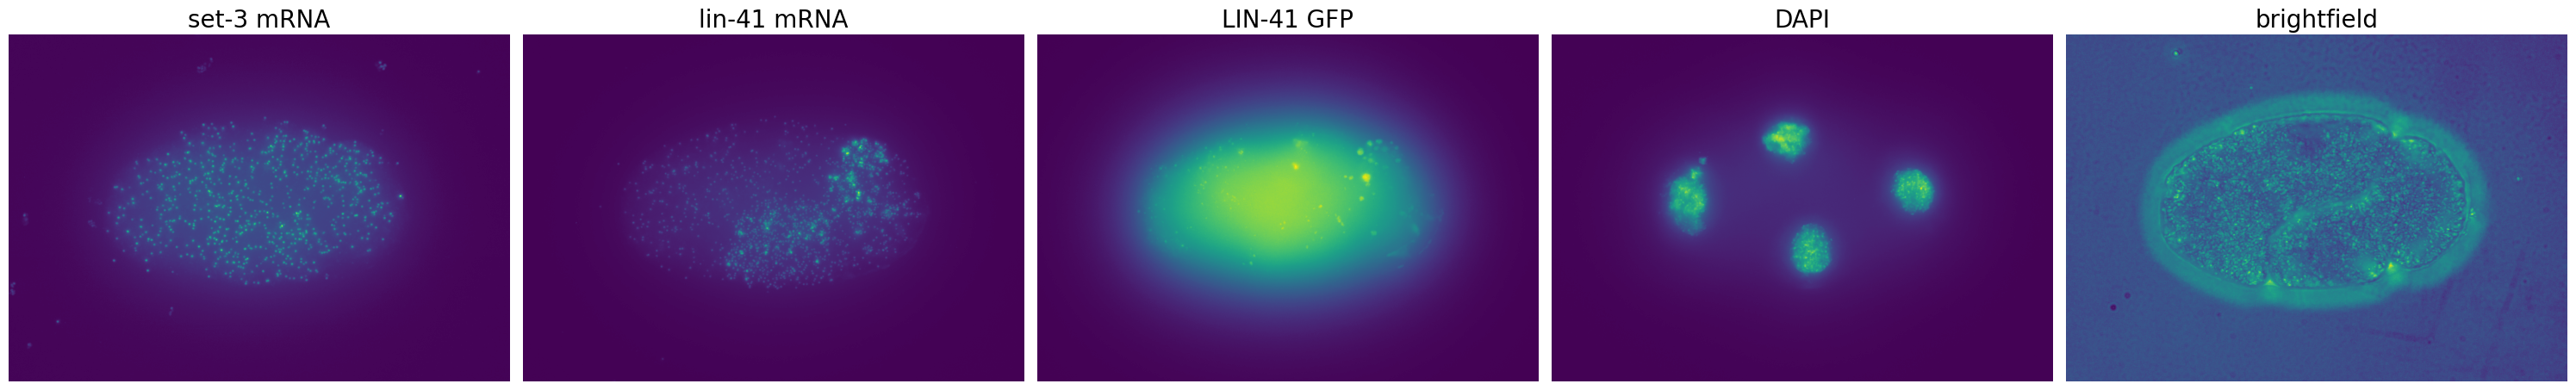

In [5]:
# Create output folder if it doesn't exist
output_folder = folder_name + "_results"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List of channel names and their corresponding images
channels = [Cy5, mCherry, FITC, DAPI, brightfield]
titles = [Cy5, mCherry, FITC, DAPI, brightfield]
images = [
    np.max(image_colors[:, 0, :, :], axis=0) if image_colors[0] is not None and Cy5 else None,
    np.max(image_colors[:, 1, :, :], axis=0) if image_colors[1] is not None and mCherry else None,
    np.max(image_colors[:, 2, :, :], axis=0) if image_colors[2] is not None and FITC else None,
    np.max(image_colors[:, 3, :, :], axis=0) if image_colors[3] is not None and DAPI else None,
    np.max(image_colors[:, 4, :, :], axis=0) if image_colors[4] is not None and brightfield else None
]

# Filter out None entries
filtered_images = [(img, title) for img, title in zip(images, titles) if img is not None]

fig, ax = plt.subplots(1, len(filtered_images), figsize=(6 * len(filtered_images), 8))

# Ensure ax is always iterable, even if there's only one plot
if len(filtered_images) == 1:
    ax = [ax]

for i, (img, title) in enumerate(filtered_images):
    ax[i].imshow(img)
    ax[i].set_title(title, size=20)
    ax[i].axis('off')

# Adjust layout if necessary
plt.tight_layout()

# Save the plots in the results folder
plt.savefig(os.path.join(output_folder, 'colors_' + image_name + '.png'))

plt.show()


#### 2.1 Segmentation

In [6]:
# Additional functions used for segmentation
def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0
    
def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
    else:
        masks_with_pairs = np.zeros_like(masks_0)
    return masks_with_pairs

def matching_masks(masks_cyto, masks_nuclei):
    n_mask_cyto = np.max(masks_cyto)
    n_mask_nuc = np.max(masks_nuclei)
    new_masks_nuclei = np.zeros_like(masks_cyto)
    reordered_mask_nuclei = np.zeros_like(masks_cyto)
    if (n_mask_cyto>0) and (n_mask_nuc>0):
        for mc in range(1,n_mask_cyto+1):
            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
            for mn in range(1,n_mask_nuc+1):
                mask_paired = False
                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                if mask_paired == True:
                    if np.count_nonzero(new_masks_nuclei) ==0:
                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                    else:
                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
            reordered_mask_nuclei = np.absolute(new_masks_nuclei)
    return reordered_mask_nuclei

def remove_extreme_values(image,min_percentile=0.1, max_percentile=99.5):
    max_val = np.percentile(image, max_percentile)
    min_val = np.percentile(image, min_percentile)
    image [image < min_val] = min_val
    image [image > max_val] = max_val
    return image

def metric_max_cells_and_area( masks):
    n_masks = np.max(masks)
    if n_masks > 1: # detecting if more than 1 mask are detected per cell
        size_mask = []
        for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
            size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
        size_masks_array = np.array(size_mask)
        metric = np.mean(size_masks_array).astype(int) * n_masks
    elif n_masks == 1: # do nothing if only a single mask is detected per image.
        approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
        metric = approximated_radius.astype(int)
    else:  # return zero if no mask are detected
        metric = 0  
    return metric   

def nuclear_segmentation(image_nuclei):
    MIN_CELL_SIZE = 1000
    list_masks_nuclei = []
    list_thresholds = np.arange(0.7,0.95, 0.05)
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_nuclei_binary = image_nuclei.copy()
        max_value_image = np.max(image_nuclei_binary)
        image_nuclei_binary[image_nuclei_binary < max_value_image*tested_ts] = 0
        image_nuclei_binary[image_nuclei_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_nuclei_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_nuclei = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_nuclei[filtered_labels == old_label] = idx
        list_masks_nuclei.append(tested_masks_nuclei)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_nuclei) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    return masks_nuclei

def cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter):
    flow_ts=1
    MIN_CELL_SIZE = 1000
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    if not (second_image_cytosol is None):
        merged_image_cytosol = np.concatenate((image_cytosol[:, :, np.newaxis], second_image_cytosol[:, :, np.newaxis]), axis=2)
        masks_cytosol_unfiltered = model.eval(merged_image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,1])[0]
    else:
        masks_cytosol_unfiltered = model.eval(image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,0])[0]
    filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)
    unique_filtered_cyto = np.unique(filtered_cyto)
    masks_cytosol = np.zeros_like(filtered_cyto)
    for idx, old_label in enumerate(unique_filtered_cyto):
        masks_cytosol[filtered_cyto == old_label] = idx
    return masks_cytosol



In [7]:
def segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter,second_image_cytosol=None):
    # Cytosol segmentation
    masks_cytosol =cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter)
    # Nuclear segmentation
    masks_nuclei = nuclear_segmentation(image_nuclei)
    # reordering nuclei masks
    masks_nuclei = matching_masks(masks_cytosol,masks_nuclei)
    # remove masks without nuclei
    masks_nuclei= remove_lonely_masks(masks_0=masks_nuclei , masks_1=masks_cytosol,is_nuc='nuc')
    masks_cytosol= remove_lonely_masks(masks_0=masks_cytosol , masks_1=masks_nuclei)
    # calculate size of masks
    number_masks_cyto = np.max(masks_cytosol)
    list_masks_cyto_sizes =[]
    for i in range (1, number_masks_cyto+1):
        list_masks_cyto_sizes.append(len(masks_cytosol[masks_cytosol==i]) )
    number_masks_nuc = np.max(masks_nuclei)
    list_masks_nuc_sizes =[]
    for i in range (1, number_masks_nuc+1):
        list_masks_nuc_sizes.append(len(masks_nuclei[masks_nuclei==i]) )
    return masks_nuclei, masks_cytosol,list_masks_nuc_sizes, list_masks_cyto_sizes

In [8]:
# Codes used to segment the nucleus and the cytosol
def segmentation(image_cytosol,image_nuclei, second_image_cytosol=None):
    # removing outliers in image
    image_cytosol = remove_extreme_values(image=image_cytosol,min_percentile=0.1, max_percentile=99.5)
    if not (second_image_cytosol is None):
        second_image_cytosol = remove_extreme_values(image=second_image_cytosol,min_percentile=0.1, max_percentile=99.5)
    image_nuclei = remove_extreme_values(image=image_nuclei,min_percentile=0.1, max_percentile=99.5)
    # Optimization segmentation
    list_masks_nuclei = []
    list_masks_cytosol=[]
    list_masks_nuc_sizes =[]
    list_masks_cyto_sizes=[]
    list_flow_thresholds = np.arange(40, 200, 10)
    array_number_detected_masks = np.zeros(len(list_flow_thresholds))
    for i,tested_ts in enumerate(list_flow_thresholds):
        tested_masks_nuclei, tested_masks_cytosol, tested_list_masks_nuc_sizes, tested_list_masks_cyto_sizes = segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter=tested_ts,second_image_cytosol=second_image_cytosol)
        list_masks_nuclei.append(tested_masks_nuclei)
        list_masks_cytosol.append(tested_masks_cytosol)
        list_masks_nuc_sizes.append(tested_list_masks_nuc_sizes)
        list_masks_cyto_sizes.append(tested_list_masks_cyto_sizes)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_cytosol) + metric_max_cells_and_area( tested_masks_nuclei)
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    masks_cytosol = list_masks_cytosol [selected_index]
    masks_nuc_sizes = list_masks_nuc_sizes[selected_index]
    masks_cyto_sizes = list_masks_cyto_sizes[selected_index]
    
        # Plotting
    color_map = 'Greys_r'
    fig, ax = plt.subplots(1,4, figsize=(14, 4))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(image_nuclei,cmap=color_map)
    ax[1].imshow(masks_nuclei,cmap=color_map)
    ax[2].imshow(image_cytosol,cmap=color_map)
    ax[3].imshow(masks_cytosol,cmap=color_map)
    ax[0].set(title='DAPI'); ax[0].axis('off');ax[0].grid(False)
    ax[1].set(title='mask nuclei'); ax[1].axis('off');ax[1].grid(False)
    ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
    ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)

#     # Save the plots in the results folder
#     plt.savefig(os.path.join(output_folder, 'segmentation_' + image_name + '.png'))
    
    return masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes

/tmp/ipykernel_578403/1281690999.py:111: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)


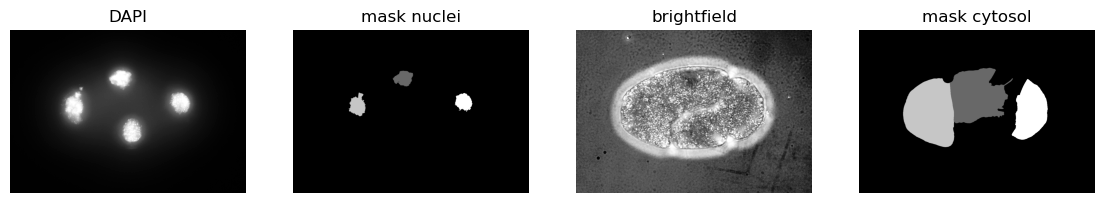

In [9]:
# # Run segmentation functions

image_nuclei = np.max(image_colors[:, 3, :, :], axis=0)
image_cytosol = np.max(image_colors[:, 4, :, :], axis=0)
second_image_cytosol = np.max(image_colors[:, 4, :, :], axis=0)
masks_cytosol, masks_nuclei,list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(image_cytosol,image_nuclei,second_image_cytosol)

segmentation_filename = os.path.join(output_folder, 'segmentation_' + image_name + '.png')

# Save the figure
plt.savefig(segmentation_filename)

In [10]:
# print(second_image_cytosol.shape)
# print(image_cytosol.shape) 
# print(image_nuclei.shape)
# print(bf.shape)
# print(masks_nuclei.shape)

#### 2.2 Spot detection

In [11]:
#@title Codes used for spot detection
# Note: spot radius = Point Spread Function (PSF)

def spot_detection(rna,voxel_size,spot_radius,masks_cytosol):
    spots, threshold = detection.detect_spots(
        images= rna,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius) 

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=3) 

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)


    # Decompose regions by simulating as many spots as possible until we match the original region intensity.
    #spots_post_decomposition = spots.copy()
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=rna,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,  # alpha impacts the number of spots per candidate region
        beta=1,  # beta impacts the number of candidate regions to decompose
        gamma=5)  # gamma the filtering step to denoise the image

    # define clusters
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=626, #626
        nb_min_spots=4)

    #plotting
#     print(f"Image ID: {image_name} \n")
    print(f"{rna_channel} detection")
    print(f" threshold: {threshold}")
    print("\r spots: {0}".format(spots_post_clustering.shape[0]))
    print("\r clusters: {0}".format(clusters.shape[0]))
   
        #elbow plot
    threshold_output = os.path.join(output_folder, rna_channel + '_threshold_' + image_name)
    plot.plot_elbow(
        images=rna,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        size_axes=8,
        framesize=(5, 3),
        title=(f"{rna_channel} detection threshold"),
        size_title=12,
        path_output=threshold_output,
        show=True  # Set show to False to prevent displaying the plot
    )



    #    # Save the plots in the results folder
    detection_output = os.path.join(output_folder, rna_channel + '_detection_' + image_name)
    plot.plot_detection(
        image=np.max(rna, axis=0),  # Assuming this is the correct way to call your function
        spots=[spots_post_decomposition, clusters[:, :3]],
        shape=["circle", "polygon"],
        radius=[1.5, 4],
        color=["red", "blue"],
        linewidth=[1, 2],
        fill=[False, True],
        contrast=True,
        framesize=(4, 4),
        title=(f"{rna_channel} detection"),
        path_output= detection_output,
        show=True
    )

    #spots_no_ts, _, ts = multistack.remove_transcription_site(spotDetectionCSV, clusterDetectionCSV, mask_nuc, ndim=3)
    #spots_in_region, _ = multistack.identify_objects_in_region(mask, spots_post_clustering[:,:3], ndim=3)

    # Separating and counting the spots in each cell
    number_masks_cyto = np.max(masks_cytosol)
    list_spots_in_each_cell =[]
    list_clusters_in_each_cell =[]
    for i in range (1, number_masks_cyto+1):
        temp_cyto_mask= np.zeros_like(masks_cytosol)
        temp_cyto_mask[masks_cytosol == i] = i
        spots_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=spots_post_clustering[:,:3], ndim=3)
        clusters_in_region,_ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=clusters[:,:3], ndim=3)
        list_spots_in_each_cell.append(len(spots_in_region))
        list_clusters_in_each_cell.append(len( clusters_in_region ))
        del spots_in_region, clusters_in_region
    return spots_post_clustering, clusters, list_spots_in_each_cell, list_clusters_in_each_cell

set-3 mRNA detection
 threshold: 45.0
 spots: 1157
 clusters: 0


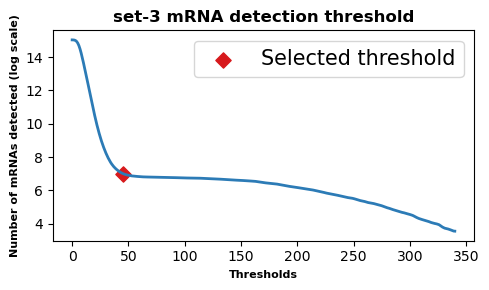

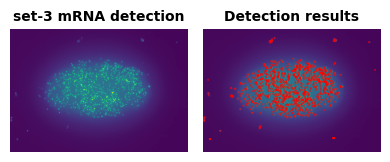

lin-41 mRNA detection
 threshold: 44.0
 spots: 2857
 clusters: 1


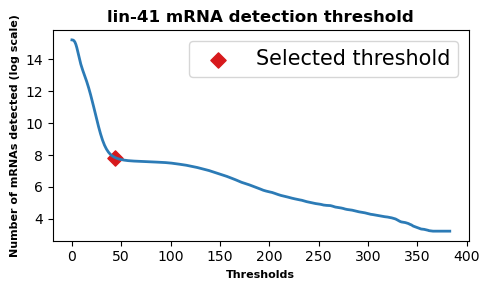

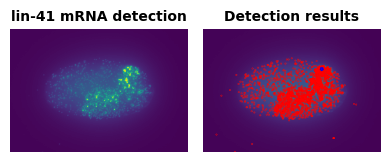

In [12]:
# voxel_size = (600, 107, 107)   # Microscope pixel size Z,Y,X
# spot_radius_ch0 = (600, 120, 120)  # PSF Z,Y,X
# spot_radius_ch1 = (600, 120, 120)  # PSF Z,Y,X

voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X
spot_radius_ch0 = (1409, 340, 340)  # PSF Z,Y,X
spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X


if Cy5 is not None and image_colors[:,0,:,:] is not None:
    rna_ch0 = image_colors[:,0,:,:] # [Z,Y,X,C]
    rna_channel = Cy5
    spots_post_clustering_ch0, clusters_ch0,list_spots_in_each_cell_ch0,list_clusters_in_each_cell_ch0 = spot_detection(rna_ch0,voxel_size,spot_radius_ch0,masks_cytosol)

if mCherry is not None and image_colors[:,1,:,:] is not None:
    rna_ch1 = image_colors[:,1,:,:] # [Z,Y,X,C]
    rna_channel = mCherry
    spots_post_clustering_ch1, clusters_ch1,list_spots_in_each_cell_ch1,list_clusters_in_each_cell_ch1 = spot_detection(rna_ch1,voxel_size,spot_radius_ch1,masks_cytosol)



#### 2.3 Data visualization and collection

##### 2.3.1 mRNA Abundance Heatmap

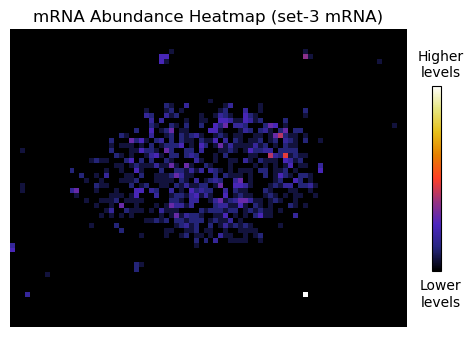

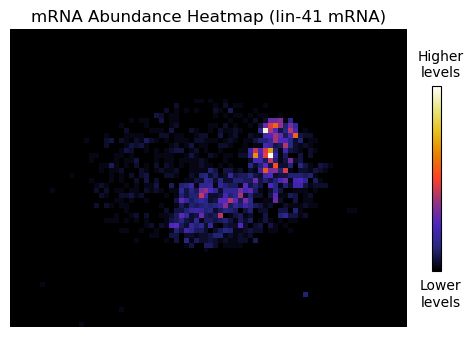

In [13]:
def create_heatmap(spots_x, spots_y, masks_cytosol, masks_nuclei, output_filename, title_suffix, grid_width=80, grid_height=60):
    # Calculate the width and height of each grid cell
    img_width, img_height = masks_cytosol.shape[1], masks_cytosol.shape[0]
    cell_width = img_width / grid_width
    cell_height = img_height / grid_height

    # Create an empty grid to store the spot counts
    grid = np.zeros((grid_height, grid_width), dtype=int)

    # Count spots in each grid cell
    for x, y in zip(spots_x, spots_y):
        # Determine which grid cell the spot belongs to
        cell_x = int(x / cell_width)
        cell_y = int(y / cell_height)

        # Increment the count in the corresponding grid cell
        if 0 <= cell_x < grid_width and 0 <= cell_y < grid_height:
            grid[cell_y, cell_x] += 1

    # Create a heatmap
    plt.imshow(masks_cytosol, cmap='gray')  # Display the original image
    plt.imshow(masks_nuclei, cmap='gray')
    plt.imshow(grid, cmap='CMRmap', alpha=1, interpolation='nearest')  # Overlay the heatmap
    plt.title(f'mRNA Abundance Heatmap ({title_suffix})')
    plt.axis('off')

    # Create a vertical color bar
    cbar = plt.colorbar(orientation='vertical', shrink=0.5)  # Adjust the shrink parameter to make it smaller
    cbar.ax.text(1, 1.05, 'Higher\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.ax.text(1, -0.19, 'Lower\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.set_ticks([])

    # Save the plots in the results folder
    plt.savefig(output_filename)
    plt.show()

# Generate heatmap for channel 0 (Cy5) if spots_post_clustering_ch0 is defined
if 'spots_post_clustering_ch0' in locals():
    spots_x_ch0 = spots_post_clustering_ch0[:, 2]
    spots_y_ch0 = spots_post_clustering_ch0[:, 1]
    create_heatmap(spots_x_ch0, spots_y_ch0, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{Cy5}_heatmap.png'), Cy5)

# Generate heatmap for channel 1 (mCherry) if spots_post_clustering_ch1 is defined
if 'spots_post_clustering_ch1' in locals():
    spots_x_ch1 = spots_post_clustering_ch1[:, 2]
    spots_y_ch1 = spots_post_clustering_ch1[:, 1]
    create_heatmap(spots_x_ch1, spots_y_ch1, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{mCherry}_heatmap.png'), mCherry)


In [14]:
# Export as csv
df_quantification = pd.DataFrame()

# Calculate the sum of each list if they are not None
if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None:
    sum_spots_ch0 = sum(list_spots_in_each_cell_ch0)
    sum_clusters_ch0 = sum(list_clusters_in_each_cell_ch0) if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None else None
else:
    sum_spots_ch0 = None
    sum_clusters_ch0 = None

if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None:
    sum_spots_ch1 = sum(list_spots_in_each_cell_ch1)
    sum_clusters_ch1 = sum(list_clusters_in_each_cell_ch1) if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None else None
else:
    sum_spots_ch1 = None
    sum_clusters_ch1 = None

# Check if any sum is not None and skip appending to df_quantification if all are None
if any(x is not None for x in [sum_spots_ch0, sum_clusters_ch0, sum_spots_ch1, sum_clusters_ch1]):
    # Create a data dictionary with summed values
    data = {
        'Image ID': image_name,
    }

    if sum_spots_ch0 is not None or sum_clusters_ch0 is not None:
        data[f'{Cy5} mRNA molecules'] = sum_spots_ch0
        data[f'{Cy5} mRNA clusters'] = sum_clusters_ch0

    if sum_spots_ch1 is not None or sum_clusters_ch1 is not None:
        data[f'{mCherry} mRNA molecules'] = sum_spots_ch1
        data[f'{mCherry} mRNA clusters'] = sum_clusters_ch1

    # Concatenate the data as a new row to the DataFrame
    df_quantification = pd.concat([df_quantification, pd.DataFrame([data])], ignore_index=True)

    quantification_output = os.path.join(output_folder, 'quantification_' + image_name + '.csv')

    # Save the DataFrame to CSV
    df_quantification.to_csv(quantification_output, index=False)

#     # Optionally, you can assign path_output to quantification_output if needed
#     path_output = quantification_output

# Display the DataFrame (optional)
df_quantification

# plot.plot_reference_spot(reference_spot, rescale=True)

,Image ID,set-3 mRNA mRNA molecules,set-3 mRNA mRNA clusters,lin-41 mRNA mRNA molecules,lin-41 mRNA mRNA clusters
0,1085_crop.nd2,700,0,1283,0


### 3. Special Features
#### 3.1 mRNA-mRNA colocalization 

In [15]:
# Print the original array
print("Original array:")
print(spots_post_clustering_ch0)

# Check dimensions and process accordingly
if spots_post_clustering_ch0.ndim == 2:
    # Remove the last column
    spots_post_clustering_ch0 = spots_post_clustering_ch0[:, :-1]

# Display the cleaned array
print("Cleaned array:")
print(spots_post_clustering_ch0)




# #Check dimensions and process accordingly
# if spots_post_clustering_ch0.ndim == 2:
#     # Check if the last column contains only -1 values
#     last_column = spots_post_clustering_ch0[:, -1]
#     print("Last column values before removal:")
#     print(last_column)

#     if np.all(last_column == -1):
#         spots_post_clustering_ch0 = spots_post_clustering_ch0[:, :-1]
#     else:
#         print("The last column does not contain only -1 values.")
# else:
#     print("The array does not have 2 dimensions.")

# # Display the cleaned array
# print("Cleaned array:")
# print(spots_post_clustering_ch0)

Original array:
[[  0 798 960  -1]
 [ 11 798 960  -1]
 [ 17 281 694  -1]
 ...
 [ 51 551 435  -1]
 [ 51 552 843  -1]
 [ 52 376 852  -1]]
Cleaned array:
[[  0 798 960]
 [ 11 798 960]
 [ 17 281 694]
 ...
 [ 51 551 435]
 [ 51 552 843]
 [ 52 376 852]]


In [16]:

# Check dimensions and process accordingly
if spots_post_clustering_ch1.ndim == 2:
    # Check if the last column contains only -1 values
    last_column = spots_post_clustering_ch1[:, -1]
    print("Last column values before removal:")
    print(last_column)

    if np.all(last_column == -1):
        spots_post_clustering_ch1 = spots_post_clustering_ch1[:, :-1]
    else:
        print("The last column does not contain only -1 values.")
else:
    print("The array does not have 2 dimensions.")

# Display the cleaned array
print("Cleaned array:")
print(spots_post_clustering_ch1)


Last column values before removal:
[-1 -1 -1 ... -1 -1 -1]
The last column does not contain only -1 values.
Cleaned array:
[[  0 798 960  -1]
 [ 13 400 831  -1]
 [ 14 471 859  -1]
 ...
 [ 50 544 936  -1]
 [ 50 546 705  -1]
 [ 50 567 675  -1]]


In [17]:
spots_post_clustering_ch1 = spots_post_clustering_ch1[:, :-1]

spot detection overlay on set-3 mRNA image
set-3 mRNA spot count: (1157, 3)


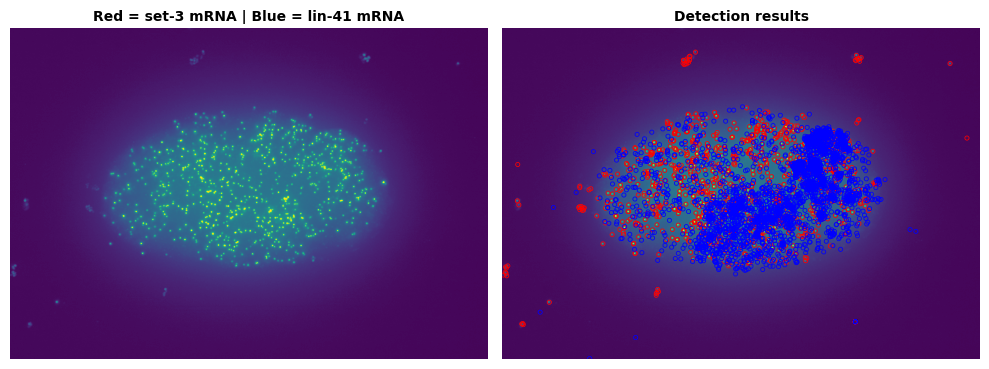

spot detection overlay on lin-41 mRNA image
lin-41 mRNA spot count: (2857, 3)


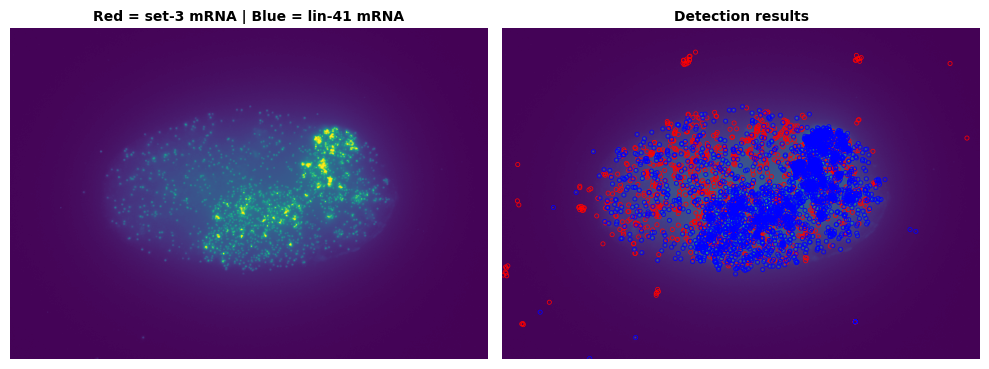

In [18]:
#mRNA
rna_max_ch0 = np.max(image_colors[:, 0, :, :], axis=0)  # Cy5 channel
rna_max_ch1 = np.max(image_colors[:, 1, :, :], axis=0)  # mCherry channel

spots_post_clustering_ch0 

#670 channel
# Check dimensions and process accordingly
if spots_post_clustering_ch0.ndim == 2:
    # Remove the last column if it contains -1 values
    if np.all(spots_post_clustering_ch0[:, -1] == -1):
        spots_post_clustering_ch0 = spots_post_clustering_ch0[:, :-1]

print(f"spot detection overlay on {Cy5} image")
print(f"{Cy5} spot count: {spots_post_clustering_ch0.shape}")

# Plot the detection
plot.plot_detection(
    rna_max_ch0,
    spots=[spots_post_clustering_ch0, spots_post_clustering_ch1], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, 
    contrast=True, 
    framesize=(10, 5)
)


# Check dimensions and process accordingly
if spots_post_clustering_ch1.ndim == 2:
    # Remove the last column if it contains -1 values
    if np.all(spots_post_clustering_ch1[:, -1] == -1):
        spots_post_clustering_ch1 = spots_post_clustering_ch1[:, :-1]

print(f"spot detection overlay on {mCherry} image")
print(f"{mCherry} spot count: {spots_post_clustering_ch1.shape}")

#610 channel
# Plot the detection
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_post_clustering_ch0, spots_post_clustering_ch1], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, 
    contrast=True, 
    framesize=(10, 5)
)



colocalized spots
 distances: (4,)


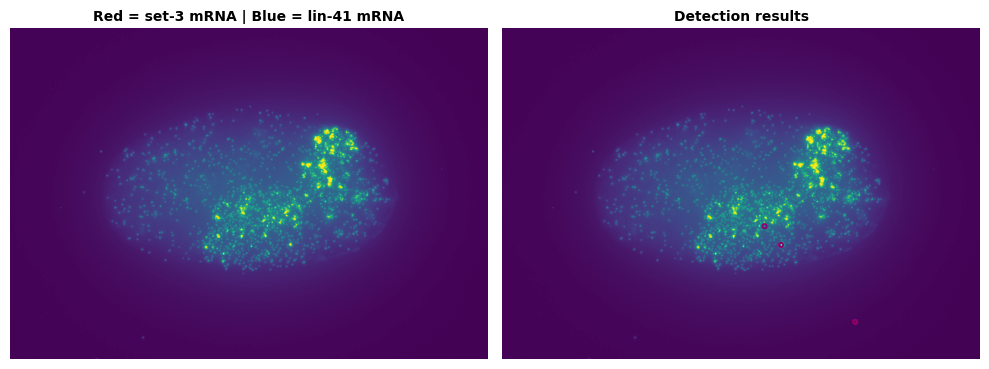

In [19]:
# Perform co-localization detection
voxel_size = (1448, 450, 450)
threshold = 5
colocalized_spots = []
(
    colocalized_spots_ch0, 
    colocalized_spots_ch1, 
    distances, 
    indices_1, 
    indices_2, 
    threshold
) = multistack.detect_spots_colocalization(
    spots_1=spots_post_clustering_ch0, #edit here to calculate co-localizatin with other things.. input coordinates here 
    spots_2=spots_post_clustering_ch1,
    voxel_size=voxel_size,
    threshold=5,  # Pass the manually set threshold
    return_indices=True,
    return_threshold=True  # To get the threshold value
)


# Print details of the co-localized spots
print("colocalized spots")
print(f"\r distances: {distances.shape}")
# print(f"\r threshold: {threshold:0.2f} nm")

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[colocalized_spots_ch0, colocalized_spots_ch1], 
    radius=2, 
    color=["red", "purple"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

#### 3.1 Nuclear colocalization (transcription sites)

detected spots (inside nuclei)
 shape: (95, 3)
detected spots (outside nuclei)
 shape: (2762, 3)


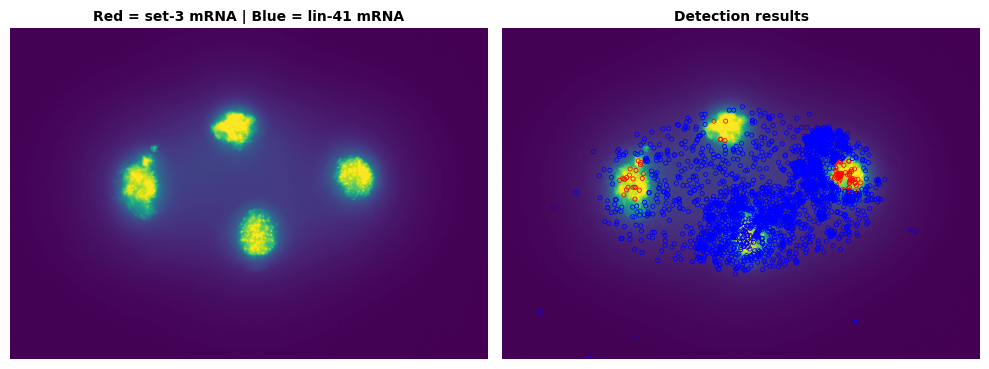

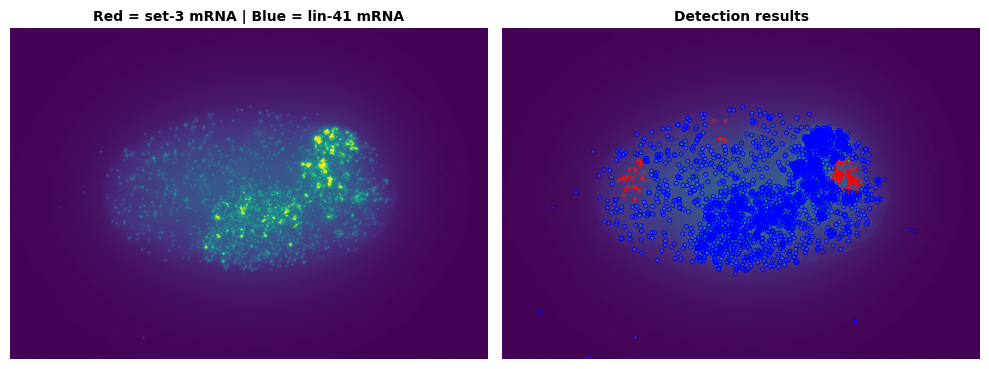

In [20]:
# nuc_max = np.max(image_colors[1, :, :, :], axis=0)  # mCherry channel

#Code to visualize colocalization with nuclei
mask = masks_nuclei
coord = spots_post_clustering_ch1
ndim = 3

spots_in, spots_out = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside nuclei)")
print("\r shape: {0}".format(spots_in.shape))

print("detected spots (outside nuclei)")
print("\r shape: {0}".format(spots_out.shape))



# plot
plot.plot_detection(
    image_nuclei,
    spots=[spots_in, spots_out], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_in, spots_out], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

#### 3.2 mRNA-p granule colocalization 

In [21]:
#p-granule mask for co-localization

# image_pgranules = np.max(image_colors[:, 2, :, :], axis=0)

# def mask_pgranule(image_pgranules):
#     MIN_CELL_SIZE = 1
#     list_masks_pgranules = []
#     list_thresholds = np.arange(0.7,0.95, 0.05)
#     array_number_detected_masks = np.zeros(len(list_thresholds))
#     for i,tested_ts in enumerate(list_thresholds):
#         image_pgranules_binary = image_pgranules.copy()
#         max_value_image = np.max(image_pgranules_binary)
#         image_pgranules_binary[image_pgranules_binary < max_value_image*tested_ts] = 0
#         image_pgranules_binary[image_pgranules_binary > max_value_image*tested_ts] = 1
#         labels = measure.label(image_pgranules_binary)
#         filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
#         unique_filtered_labels = np.unique(filtered_labels)
#         tested_masks_pgranules = np.zeros_like(filtered_labels)
#         for idx, old_label in enumerate(unique_filtered_labels):
#             tested_masks_pgranules[filtered_labels == old_label] = idx
#         list_masks_pgranules.append(tested_masks_pgranules)
#         array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_pgranules) 
#     selected_index = np.argmax(array_number_detected_masks)
#     masks_pgranules = list_masks_pgranules [selected_index]
#     return masks_pgranules

# # Assume image_pgranules is already defined as the max projection of the third channel
# image_pgranules = np.max(image_colors[2, :, :, :], axis=0)
# masks_pgranules = mask_pgranule(image_pgranules)


# # Plotting
# color_map = 'Greys_r'
# fig, ax = plt.subplots(1,4, figsize=(14, 4))
# # Plotting the heatmap of a section in the image
# ax[0].imshow(image_pgranules,cmap=color_map)
# ax[1].imshow(masks_pgranules,cmap=color_map)
# ax[2].imshow(image_cytosol,cmap=color_map)
# ax[3].imshow(masks_cytosol,cmap=color_map)
# ax[0].set(title='p granules'); ax[0].axis('off');ax[0].grid(False)
# ax[1].set(title='mask p granules'); ax[1].axis('off');ax[1].grid(False)
# ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
# ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)


In [22]:
#Code to visualize colocalization with p granules

# mask = masks_pgranules
# coord = spots_post_clustering_ch1
# ndim = 3

# spots_in, spots_out = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# # spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
# print("detected spots (inside p-granules)")
# print("\r shape: {0}".format(spots_in.shape))
# print("\r dtype: {0}".format(spots_in.dtype), "\n")
# print("detected spots (outside p-granules)")
# print("\r shape: {0}".format(spots_out.shape))
# print("\r dtype: {0}".format(spots_out.dtype))


# # plot
# plot.plot_detection(
#     rna_max_ch1,
#     spots=spots_in, 
#     radius=1, 
#     color="red",
#     title="Red = mRNA in p-granules",
#     linewidth=3, contrast=True, framesize=(10, 5))

In [23]:
#pdf report

#Specify the size of items in the report

output_pdf_path = os.path.join(output_folder, "report.pdf")

def create_image_report(output_folder, output_pdf_path, additional_info="", crop_top=0):
    image_files = [f for f in os.listdir(output_folder) if f.endswith(".png")]

    # Create a PDF document
    pdf_path = output_pdf_path
    c = canvas.Canvas(pdf_path, pagesize=letter)

    # Add additional information to the report
    if additional_info:
        c.drawString(100, 750, additional_info)

    # Set initial coordinates for the first image
    x_coordinate = -50
    y_coordinate = 525

    # Set the vertical spacing between rows
    row_spacing = 140

    # Reverse the order of image_files
    image_files.reverse()

    # Loop through each image and add it to the PDF
    for image_file in image_files:
        image_path = os.path.join(output_folder, image_file)

        # Convert the PNG image to PDF using PIL
        img = Image.open(image_path)

        # Crop the top of the image
        img = img.crop((0, crop_top, img.width, img.height))

        # Draw the image at the current coordinates
        c.drawInlineImage(img, x_coordinate, y_coordinate, width=700, height=200)

        # Update the coordinates for the next image in the same row
        x_coordinate += 700 + 20  # Add space between images

        # Check if a new row is needed
        if x_coordinate > 500:
            x_coordinate = -50
            y_coordinate -= row_spacing  # Move to the next row

        # Add a new page if needed (you might want to adjust this condition based on your preference)
        if y_coordinate < 50:
            c.showPage()
            x_coordinate = -50
            y_coordinate = 595 - row_spacing  # Move to the next row

    # Save the PDF
    c.save()
    print(f"PDF report created: {pdf_path}")

from datetime import date

# Example usage with cropping 50 pixels from the top of each image
report_name = f'Report-{date.today()}'
create_image_report(output_folder, output_pdf_path, report_name, crop_top=60)



PDF report created: /pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_nd2_test-files_results/report.pdf
